# 用 RNN 做时间序列预测

In [1]:
import math
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from utils import data_tools, networks_factory, data_metrics
from utils.constants import const
%matplotlib inline

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

## 导入数据

# shape:  (1901, 1)


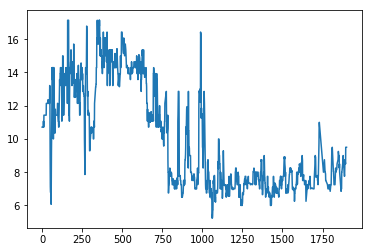

In [5]:
dataset, dates = data_tools.load_data_from_csv(const.DATA_DIR + "apple_interpolate.csv")
print("# shape: ", dataset.shape)

plt.plot(dataset)
plt.show()

## 数据转化与处理

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

In [7]:
# reshape into X=t and Y=t+1
look_back = const.LOOK_BACK
dataX, dataY = data_tools.create_dataset(scaled_dataset, look_back)
dataY = dataY.reshape((len(dataY), 1))  # to be two dims for inverse_transform
print("# shape: ", dataX.shape)  # lenth 应等于 len(dataset)-look_back
print("# shape: ", dataY.shape)

# shape:  (1871, 30)
# shape:  (1871, 1)


In [8]:
train_size = int(len(dataX) * const.TRAIN_SCALE)
test_size = len(dataX) - train_size
trainX, testX = dataX[0:train_size,:], dataX[train_size:len(dataset),:]
trainY, testY = dataY[0:train_size,:], dataY[train_size:len(dataset),:]
print("# lenth: ", len(trainX), len(testX))
print(len(dataX) == len(trainX)+len(testX))

# lenth:  1496 375
True


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: **[samples, time steps, features]**.

Currently, our data is in the form: **[samples, features]** and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [9]:
# reshape input to be [samples, time steps, features]
time_steps = look_back
trainX = numpy.reshape(trainX, (trainX.shape[0], time_steps, trainX.shape[1]//time_steps)) 
print(trainX.shape)
testX = numpy.reshape(testX, (testX.shape[0], time_steps, testX.shape[1]//time_steps))
print(testX.shape)

(1496, 30, 1)
(375, 30, 1)


## 建立 SimpleRNN 模型

In [10]:
n_dims = trainX.shape[2]
# create and fit the RNN network
model = s, model = networks_factory.create_rnn_model(hidden_neurons=32, lenth=time_steps, dims=n_dims, n_out=1)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=const.VALIDATION_SCALE, verbose=1)
# epochs=30, nearly converge

Train on 1122 samples, validate on 374 samples
Epoch 1/10
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1296 - val_loss: 0.1083
Epoch 2/10
1122/1122 [==============================] - 1s 494us/step - loss: 0.0664 - val_loss: 0.1382
Epoch 3/10
1122/1122 [==============================] - 1s 508us/step - loss: 0.0648 - val_loss: 0.1161
Epoch 4/10
1122/1122 [==============================] - 1s 513us/step - loss: 0.0643 - val_loss: 0.1468
Epoch 5/10
1122/1122 [==============================] - 1s 550us/step - loss: 0.0554 - val_loss: 0.0695
Epoch 6/10
1122/1122 [==============================] - 1s 520us/step - loss: 0.0226 - val_loss: 0.0075
Epoch 7/10
1122/1122 [==============================] - 1s 554us/step - loss: 0.0187 - val_loss: 0.0072
Epoch 8/10
1122/1122 [==============================] - 1s 598us/step - loss: 0.0135 - val_loss: 0.0059
Epoch 9/10
1122/1122 [==============================] - 1s 547us/step - loss: 0.0123 - val_loss: 0.0017
Epoch 10/10
1122/11

## 预测评估

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.04 RMSE
Test Score: 0.49 RMSE


## 画出结果

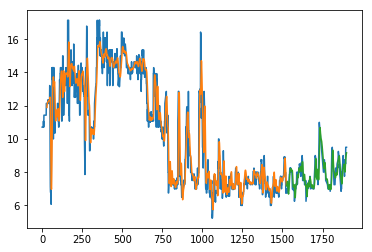

In [12]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:,:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict[:]  # index from a to b-1

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset),:] = testPredict[:]

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

参考：[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"Title")